### Load in all the data 

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, f1_score, recall_score, precision_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from xgboost import XGBClassifier
import warnings
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from itertools import product
from sklearn.metrics import classification_report
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mordred import Calculator, descriptors

#For reproducibility
np.random.seed(42)

#Load the data
file_path = r"C:\Users\20191136\Downloads\tested_molecules.csv"
data = pd.read_csv(file_path)
data_all = data
data = data.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])
# Function to calculate descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(Descriptors.descList)
    return [func(mol) for name, func in Descriptors.descList]

# Calculate descriptors for all SMILES
descriptor_names = [name for name, func in Descriptors.descList]
descriptor_values = data['SMILES'].apply(calculate_descriptors)

# Create a DataFrame with descriptor values
descriptor_df = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_names)

descriptor_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,58,...,0,0,0,0,0,0,0,0,0,0
1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,88,...,0,0,0,0,0,0,0,0,0,0
2,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,84,...,0,0,0,0,0,0,0,0,0,0
3,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,0,0
4,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,80,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,12.955843,12.955843,0.016627,-0.290408,0.764433,17.703704,362.385,344.241,362.126657,136,...,0,0,0,0,0,0,0,0,0,0
1112,12.983770,12.983770,0.009487,-3.772852,0.594812,11.720000,374.442,361.338,374.042773,126,...,0,1,0,0,0,1,0,0,0,0
1113,10.579691,10.579691,0.249681,0.249681,0.753119,15.640000,355.849,335.689,355.132015,128,...,0,0,0,0,0,0,0,0,0,0
1114,4.812249,4.812249,0.983396,0.983396,0.738254,14.956522,322.437,304.293,322.125218,116,...,0,0,0,0,0,1,0,0,0,0


### load in specific descriptors 

In [44]:
specific_descriptors=  ['fr_allylic_oxid', 'PEOE_VSA13', 'fr_Ar_N', 'EState_VSA6', 'Kappa3', 'EState_VSA8',
                       'SMR_VSA1', 'fr_sulfonamd', 'SlogP_VSA3', 'NumAromaticHeterocycles', 'SMR_VSA3', 'EState_VSA1', 'fr_NH0', 'PEOE_VSA3',
                        'PEOE_VSA14', 'SlogP_VSA11', 'SMR_VSA2', 'NumAliphaticHeterocycles', 'Ipc', 'PEOE_VSA8', 'BCUT2D_MWHI' 
                        ,'fr_unbrch_alkane', 'SlogP_VSA8', 'VSA_EState6', 'SlogP_VSA1', 'EState_VSA4', 'PEOE_VSA2','VSA_EState3']
specific_descriptor_df = descriptor_df[specific_descriptors]
specific_descriptor_df.head()

,fr_allylic_oxid,PEOE_VSA13,fr_Ar_N,EState_VSA6,Kappa3,EState_VSA8,SMR_VSA1,fr_sulfonamd,SlogP_VSA3,NumAromaticHeterocycles,...,Ipc,PEOE_VSA8,BCUT2D_MWHI,fr_unbrch_alkane,SlogP_VSA8,VSA_EState6,SlogP_VSA1,EState_VSA4,PEOE_VSA2,VSA_EState3
0,1,0.000000,3,6.923737,1.635047,21.530871,0.000000,0,0.000000,1,...,243.678177,0.000000,15.136768,0,5.573105,0.000000,11.467335,0.000000,0.000000,0.000000
1,0,0.000000,0,12.132734,2.683837,6.578936,9.154014,0,0.000000,1,...,6646.697850,22.551245,35.495704,0,10.969244,6.779888,10.362449,10.949676,0.000000,1.303187
2,0,0.000000,0,12.152040,8.742061,23.791449,9.589074,0,9.589074,0,...,1767.079749,25.931156,16.151392,0,0.000000,0.000000,10.633577,0.000000,9.589074,5.288719
3,0,5.693928,2,24.265468,1.753868,6.578936,9.567996,0,0.000000,1,...,8230.924683,12.990104,16.658607,0,11.033401,6.777354,15.127263,4.730408,4.794537,11.802716
4,2,5.559267,2,6.076020,2.274281,13.157871,0.000000,0,13.089513,1,...,2047.621158,19.286356,35.495691,0,0.000000,0.000000,11.249010,4.567100,13.928736,0.012315


### Perform PCA and find the thresholds

In [25]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def check_all_thresholds(data, descriptor_df, constant_bits, threshold_finger_prints, threshold_descriptors):
    np.random.seed(42)
    
    def smiles_to_fingerprint(smiles, nBits=constant_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
            return np.array(fp)
        else:
            return np.zeros((nBits,))

    # Apply the function to your dataset with nBits=1024
    fingerprints = data['SMILES'].apply(lambda x: smiles_to_fingerprint(x, nBits=constant_bits))
    fingerprints_matrix = np.stack(fingerprints.values)
    
    # Standardize the fingerprints
    scaler_fp = StandardScaler()
    scaled_fingerprints = scaler_fp.fit_transform(fingerprints_matrix)
    
    # Perform PCA on fingerprints
    pca_fp = PCA()
    pca_fp.fit(scaled_fingerprints)
    
    # Determine the number of components to retain 90% variance
    cumulative_variance_fp = pca_fp.explained_variance_ratio_.cumsum()
    num_components_fp = (cumulative_variance_fp < threshold_finger_prints).sum() + 1
    
    # Transform the dataset using these components
    pca_fp = PCA(n_components=num_components_fp)
    principal_components_fp = pca_fp.fit_transform(scaled_fingerprints)
    
    # Create a DataFrame with the principal components
    pca_fp_df = pd.DataFrame(data=principal_components_fp)

    # Combine PCA and descriptors DataFrames
    combined_df = pd.concat([descriptor_df, pca_fp_df], axis=1)
    combined_df.columns = combined_df.columns.astype(str)

    # Standardize the combined data
    scaler_combined = StandardScaler()
    scaled_combined_data = scaler_combined.fit_transform(combined_df)
    
    # Perform PCA on combined data
    pca_combined = PCA()
    pca_combined.fit(scaled_combined_data)
    
    # Determine the number of components to retain 90% variance
    cumulative_variance_combined = pca_combined.explained_variance_ratio_.cumsum()
    num_components_combined = (cumulative_variance_combined < threshold_descriptors).sum() + 1
    
    # Transform the dataset using these components
    pca_combined = PCA(n_components=num_components_combined)
    principal_components_combined = pca_combined.fit_transform(scaled_combined_data)

    final_pca_df = pd.DataFrame(data=principal_components_combined)
    final_pca_df.columns = final_pca_df.columns.astype(str)
    
    # Save the fitted PCA and scalers for later use on the testing set
    return final_pca_df, pca_combined, scaler_combined, pca_fp, scaler_fp

def transform_test_data(test_data, descriptor_test_df, pca_combined, scaler_combined, pca_fp, scaler_fp, constant_bits):
    def smiles_to_fingerprint(smiles, nBits=constant_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
            return np.array(fp)
        else:
            return np.zeros((nBits,))

    # Apply the function to your test dataset with nBits=1024
    fingerprints_test = test_data['SMILES'].apply(lambda x: smiles_to_fingerprint(x, nBits=constant_bits))
    fingerprints_test_matrix = np.stack(fingerprints_test.values)
    
    # Standardize the fingerprints using the scaler fitted on the training set
    scaled_fingerprints_test = scaler_fp.transform(fingerprints_test_matrix)
    
    # Transform the test set fingerprints using the PCA fitted on the training set
    principal_components_fp_test = pca_fp.transform(scaled_fingerprints_test)
    
    # Create a DataFrame with the principal components
    pca_fp_test_df = pd.DataFrame(data=principal_components_fp_test)

    # Combine PCA and descriptors DataFrames for the test set
    combined_test_df = pd.concat([descriptor_test_df, pca_fp_test_df], axis=1)
    combined_test_df.columns = combined_test_df.columns.astype(str)

    # Standardize the combined data using the scaler fitted on the training set
    scaled_combined_test_data = scaler_combined.transform(combined_test_df)
    
    # Transform the combined test set using the PCA fitted on the training set
    principal_components_combined_test = pca_combined.transform(scaled_combined_test_data)

    final_pca_test_df = pd.DataFrame(data=principal_components_combined_test)
    final_pca_test_df.columns = final_pca_test_df.columns.astype(str)
    
    return final_pca_test_df


### Function to train & evaluate the model 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
import warnings
import joblib

def check_with_model(descriptor_df):
    np.random.seed(42)
    # Assuming your descriptor_df is already prepared
    X = descriptor_df.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])
    y1 = descriptor_df['PKM2_inhibition']
    y2 = descriptor_df['ERK2_inhibition']
    y = pd.concat([y1, y2], axis=1)
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Ignore all warnings
    warnings.filterwarnings("ignore")
    
    # Apply RandomOverSampler to handle imbalance for each target separately
    ros_pkm2 = RandomOverSampler(random_state=42)
    X_train_ros_pkm2, y_train_ros_pkm2 = ros_pkm2.fit_resample(X_train_scaled, y_train['PKM2_inhibition'])
    
    ros_erk2 = RandomOverSampler(random_state=42)
    X_train_ros_erk2, y_train_ros_erk2 = ros_erk2.fit_resample(X_train_scaled, y_train['ERK2_inhibition'])
    
    # Calculate scale_pos_weight for each target
    scale_pos_weight_pkm2 = y_train_ros_pkm2.value_counts()[0] / y_train_ros_pkm2.value_counts()[1]
    scale_pos_weight_erk2 = y_train_ros_erk2.value_counts()[0] / y_train_ros_erk2.value_counts()[1]
    
    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [50,100, 200,300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2,0.3,0.4],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
        'reg_lambda': [0, 1, 10]  # L2 regularization
    }

    # Function to perform grid search and return the best parameters
    def perform_grid_search(X_train, y_train):
        model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=3)
        grid_search.fit(X_train, y_train)
        print(f"Best parameters found: {grid_search.best_params_}")
        return grid_search.best_params_

    # Fine-tune models using GridSearchCV
    best_params_pkm2 = perform_grid_search(X_train_ros_pkm2, y_train_ros_pkm2)
    best_params_erk2 = perform_grid_search(X_train_ros_erk2, y_train_ros_erk2)
    
    # Create and train the XGBClassifier for PKM2_inhibition with the best parameters
    model_pkm2 = XGBClassifier(**best_params_pkm2, scale_pos_weight=scale_pos_weight_pkm2, random_state=42, use_label_encoder=False, eval_metric='logloss')
    eval_set_pkm2 = [(X_train_ros_pkm2, y_train_ros_pkm2), (X_val_scaled, y_val['PKM2_inhibition'])]
    model_pkm2.fit(X_train_ros_pkm2, y_train_ros_pkm2, eval_set=eval_set_pkm2, early_stopping_rounds=10, verbose=False)
    
    # Create and train the XGBClassifier for ERK2_inhibition with the best parameters
    model_erk2 = XGBClassifier(**best_params_erk2, scale_pos_weight=scale_pos_weight_erk2, random_state=42, use_label_encoder=False, eval_metric='logloss')
    eval_set_erk2 = [(X_train_ros_erk2, y_train_ros_erk2), (X_val_scaled, y_val['ERK2_inhibition'])]
    model_erk2.fit(X_train_ros_erk2, y_train_ros_erk2, eval_set=eval_set_erk2, early_stopping_rounds=10, verbose=False)
    
    # Save the trained models
    joblib.dump(model_pkm2, 'model_pkm2.pkl')
    joblib.dump(model_erk2, 'model_erk2.pkl')
    
    # Save the scaler
    joblib.dump(scaler, 'scaler.pkl')
    
    # Predict on the validation set
    y_pred_pkm2 = model_pkm2.predict(X_val_scaled)
    y_pred_erk2 = model_erk2.predict(X_val_scaled)
    
    # Convert y_val to numpy array for comparison
    y_val_binary = y_val.to_numpy()
    
    # Calculate the accuracy, precision, recall, F1 score for each target column
    accuracy_pkm2 = accuracy_score(y_val_binary[:, 0], y_pred_pkm2)
    accuracy_erk2 = accuracy_score(y_val_binary[:, 1], y_pred_erk2)
    
    precision_pkm2 = precision_score(y_val_binary[:, 0], y_pred_pkm2)
    precision_erk2 = precision_score(y_val_binary[:, 1], y_pred_erk2)
    
    recall_pkm2 = recall_score(y_val_binary[:, 0], y_pred_pkm2)
    recall_erk2 = recall_score(y_val_binary[:, 1], y_pred_erk2)
    
    f1_pkm2 = f1_score(y_val_binary[:, 0], y_pred_pkm2)
    f1_erk2 = f1_score(y_val_binary[:, 1], y_pred_erk2)
    
    # Print the classification reports
    print("Classification report for PKM2_inhibition:")
    print(classification_report(y_val_binary[:, 0], y_pred_pkm2))

    print("Classification report for ERK2_inhibition:")
    print(classification_report(y_val_binary[:, 1], y_pred_erk2))
    
    # Combine the predictions for both targets
    y_pred_combined = pd.concat([pd.Series(y_pred_pkm2, name='PKM2_inhibition'), pd.Series(y_pred_erk2, name='ERK2_inhibition')], axis=1)
    print("Predicted binary values:\n", y_pred_combined)
    
    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'PKM2_inhibition': [accuracy_pkm2, precision_pkm2, recall_pkm2, f1_pkm2],
        'ERK2_inhibition': [accuracy_erk2, precision_erk2, recall_erk2, f1_erk2]
    })
    
    # Transpose the DataFrame for the desired format
    results = results.set_index('Metric').T
    
    # Plot loss curves
    epochs_pkm2 = range(1, len(model_pkm2.evals_result()['validation_0']['logloss']) + 1)
    epochs_erk2 = range(1, len(model_erk2.evals_result()['validation_0']['logloss']) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_pkm2, model_pkm2.evals_result()['validation_0']['logloss'], label='Training Loss')
    plt.plot(epochs_pkm2, model_pkm2.evals_result()['validation_1']['logloss'], label='Validation Loss')
    plt.title('PKM2_inhibition Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_erk2, model_erk2.evals_result()['validation_0']['logloss'], label='Training Loss')
    plt.plot(epochs_erk2, model_erk2.evals_result()['validation_1']['logloss'], label='Validation Loss')
    plt.title('ERK2_inhibition Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results


### Obtain final PCA
##### perform it with all data --> descriptor_df 
##### perform it with specific descriptorn in the data  --> specific_descriptor_df 


In [45]:
# Define constants
constant_bits = 512
threshold_finger_prints = 0.20
threshold_descriptors =0.6000000000000001

# Apply PCA on training data
final_pca_df, pca_combined, scaler_combined, pca_fp, scaler_fp = check_all_thresholds(
    data, specific_descriptor_df, constant_bits, threshold_finger_prints, threshold_descriptors
) # choose = decriptor_df or specific_descriptor_df 

### Train and evaluate the model 

Final PCA dataset with 90% variance saved as 'final_pca_dataset.csv'
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 0.8}
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
Classification report for PKM2_inhibition:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       545
           1       0.07      0.08      0.07        13

    accuracy                           0.96       558
   macro avg       0.52      0.53      0.53       558
weighted avg       0.96      0.96      0.96       558

Classification report for ERK2_inhibition:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       532
           1       0.05      0.04      0.04        26

    accuracy                      

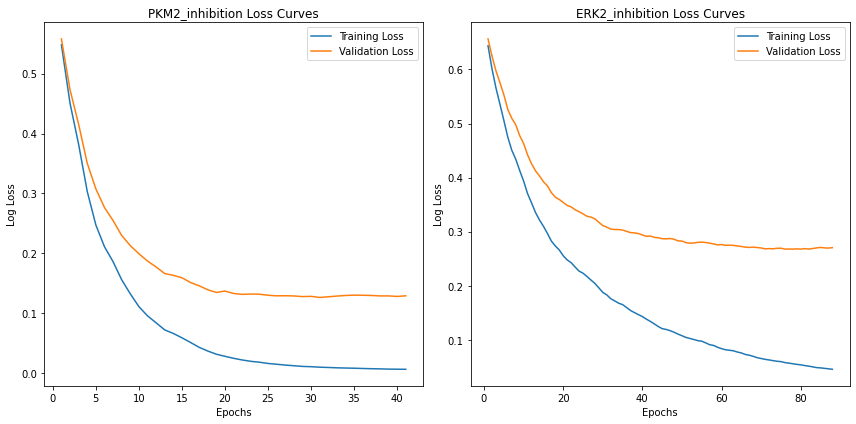

Metric,Accuracy,Precision,Recall,F1 Score
PKM2_inhibition,0.955197,0.071429,0.076923,0.074074
ERK2_inhibition,0.922939,0.052632,0.038462,0.044444


In [46]:
# Save the final PCA dataset
final_pca_df.to_csv('final_pca_dataset.csv', index=False)
final_pca_df['PKM2_inhibition'] = data_all['PKM2_inhibition']
final_pca_df['ERK2_inhibition'] = data_all['ERK2_inhibition']

print("Final PCA dataset with 90% variance saved as 'final_pca_dataset.csv'")

results = check_with_model(final_pca_df)
results

### Load in the testing data 

In [47]:

# Path to the testing set
test_path = r"C:\Users\20191136\Downloads\untested_molecules-3.csv"
untested_data = pd.read_csv(test_path)

untested_data = untested_data.drop(columns=['PKM2_inhibition', 'ERK2_inhibition'])

# Calculate descriptors for all SMILES

untested_descriptor_values = untested_data['SMILES'].apply(calculate_descriptors)
# Create a DataFrame with descriptor values
untested_descriptor_df = pd.DataFrame(untested_descriptor_values.tolist(), columns=descriptor_names)

untested_descriptor_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.102478,12.102478,0.021321,-0.399409,0.573774,17.650000,296.396,276.236,296.130697,110,...,1,0,0,0,0,0,0,0,0,0
1,11.985063,11.985063,0.021654,-0.120596,0.919617,13.454545,316.382,300.254,316.088163,114,...,0,0,0,0,0,0,0,1,0,0
2,12.287562,12.287562,0.163668,0.163668,0.727985,15.782609,333.441,312.273,333.149207,122,...,1,0,0,0,1,0,0,0,0,0
3,11.932898,11.932898,0.197446,-4.142696,0.601737,12.800000,301.255,283.111,301.084649,112,...,0,0,0,0,0,0,0,0,0,0
4,11.589256,11.589256,0.075648,-0.346925,0.806028,10.000000,244.250,232.154,244.084792,92,...,0,0,0,0,0,0,0,0,0,0


### specific descriptors for the Test data 

In [49]:
specific_untested_df= untested_descriptor_df[specific_descriptors] # use when you only want to test specific descriptors 

### PCA on the testing data 

In [50]:
final_pca_test_df = transform_test_data(
    untested_data, specific_untested_df, pca_combined, scaler_combined, pca_fp, scaler_fp, constant_bits
)   # when using specif untested descriptors change to specific_untested_df 

### Evaluate the models performance on the test set 

In [51]:
import joblib
import pandas as pd

# Load the saved models
model_pkm2 = joblib.load('model_pkm2.pkl')
model_erk2 = joblib.load('model_erk2.pkl')

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Use the models for prediction
y_pred_pkm2 = model_pkm2.predict(final_pca_test_df)
y_pred_erk2 = model_erk2.predict(final_pca_test_df)

# Create a DataFrame to store the predictions
predictions = pd.DataFrame({
    'PKM2_inhibition': y_pred_pkm2,
    'ERK2_inhibition': y_pred_erk2
})

# Calculate the counts of each combination
counts = predictions.value_counts().reset_index(name='Count')

# Rename the columns for better understanding
counts.columns = ['PKM2_inhibition', 'ERK2_inhibition', 'Count']

# Display the counts
print(counts)

   PKM2_inhibition  ERK2_inhibition  Count
0                0                0   4291
1                0                1    112
2                1                0     55
3                1                1      2
